# Imports Library

In [ ]:
import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,VGG16,VGG19, MobileNetV2, ResNet50, ResNet101,ResNet152, InceptionV3,InceptionResNetV2,DenseNet121,DenseNet169,DenseNet201,Xception,NASNetMobile, NASNetLarge
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
DATA_PATH = "/kaggle/input/preprocess-dataset-augmentation/AD_AUG"

In [ ]:
def load_data(data_path):
    all_paths = glob.glob(f'{data_path}/**/*.*', recursive=True)
    labels = [os.path.split(os.path.split(path)[0])[1] for path in all_paths]
    return pd.DataFrame({'Filepath': all_paths, 'Target': labels}).sample(frac=1).reset_index(drop=True)

dataframe = load_data(DATA_PATH)

In [ ]:
def explore_data(df):
    print("Dataset shape:", df.shape)
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Target')
    plt.title("Distribution of Classes")
    plt.show()

Dataset shape: (12010, 2)


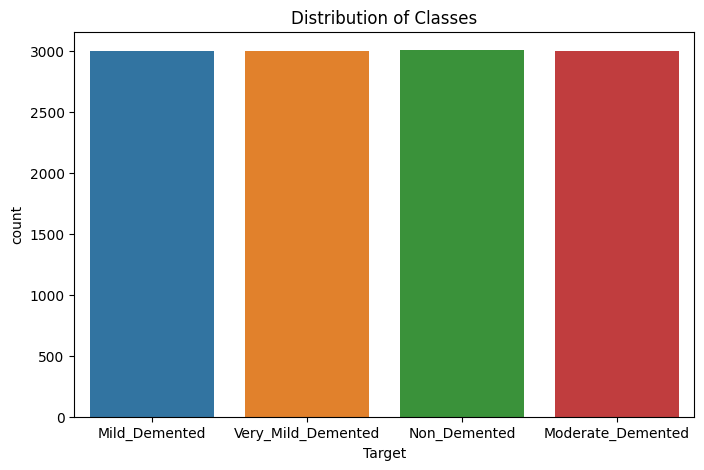

In [ ]:
dataframe = load_data(DATA_PATH)
explore_data(dataframe)

# Preprocessing and Feature Extraction

In [ ]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing: Grayscale,Denoising,CLAHE,Resize,Rescale
#Local Binary Pattern (LBP) for feature extraction

def preprocess_image(filepath):

    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

    image = cv2.resize(image, (128, 128))

    image = image / 255.0

    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")

    return lbp

# Data Split 80:20


In [ ]:
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)

Found 9608 validated image filenames belonging to 4 classes.
Found 2402 validated image filenames belonging to 4 classes.


# ResNet50  









In [ ]:

pretrained_model = ResNet50(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 35s 40ms/step - accuracy: 0.6449 - loss: 0.8581 - val_accuracy: 0.8572 - val_loss: 0.4068
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.8772 - loss: 0.3552 - val_accuracy: 0.8922 - val_loss: 0.2831
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.9154 - loss: 0.2446 - val_accuracy: 0.9213 - val_loss: 0.2137
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - accuracy: 0.9420 - loss: 0.1753 - val_accuracy: 0.9346 - val_loss: 0.1775
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.9507 - loss: 0.1432 - val_accuracy: 0.9321 - val_loss: 0.1678
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.9605 - loss: 0.1198 - val_accuracy: 0.9542 - val_loss: 0.1234
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.9630 - loss: 0.1033 - val_accuracy: 0.9538 - val_loss: 0.1267
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.9712 - loss: 0.0871 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9795 - loss: 0.0668
Test Loss: 0.056416284292936325
Test Accuracy: 0.9820982217788696


**Training and validation accuracy and loss curve**

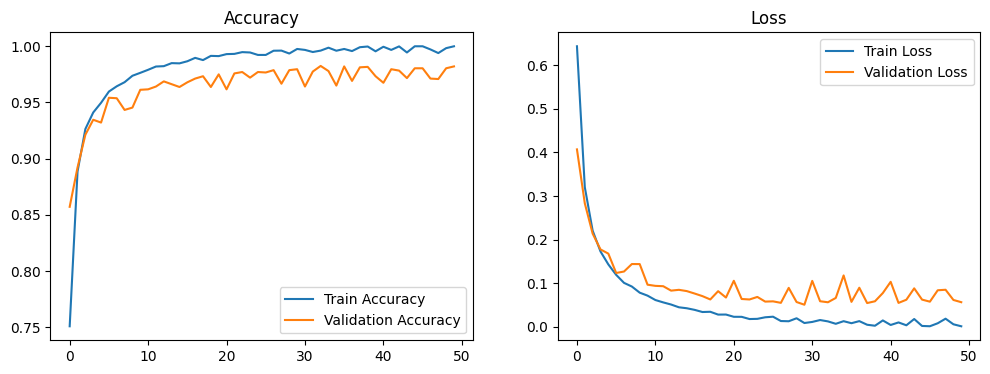

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


**Model Evaluation**

151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.97      0.97      0.97       596
 Moderate_Demented       1.00      1.00      1.00       606
      Non_Demented       1.00      1.00      1.00       606
Very_Mild_Demented       0.97      0.96      0.97       594

          accuracy                           0.98      2402
         macro avg       0.98      0.98      0.98      2402
      weighted avg       0.98      0.98      0.98      2402



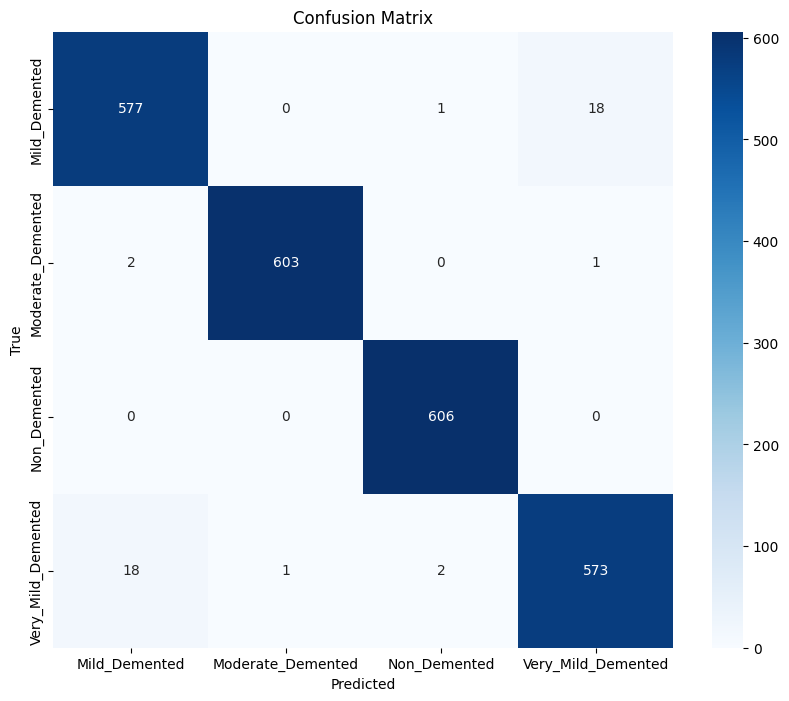

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# CNN

In [ ]:
def create_model(input_shape=(128, 128) + (3,)):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(len(train_data.class_indices), activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = create_model()

In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 127008)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │      16,257,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,258,564 (62.02 MB)

 Trainable params: 16,258,564 (62.02 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def train_model(model, train_data, test_data, epochs=50):
    history = model.fit(
        train_data,
        validation_data=test_data,
        epochs=epochs
    )
    return history

In [ ]:
history = train_model(model, train_data, test_data)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 13s 17ms/step - accuracy: 0.3751 - loss: 10.1497 - val_accuracy: 0.4538 - val_loss: 1.0972
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.4286 - loss: 1.1784 - val_accuracy: 0.4646 - val_loss: 0.9821
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.4755 - loss: 1.0299 - val_accuracy: 0.5487 - val_loss: 0.8491
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.5088 - loss: 0.9442 - val_accuracy: 0.4829 - val_loss: 0.8703
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5112 - loss: 0.9030 - val_accuracy: 0.5837 - val_loss: 0.7883
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - accuracy: 0.5604 - loss: 0.8357 - val_accuracy: 0.5895 - val_loss: 0.7559
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.5771 - loss: 0.8235 - val_accuracy: 0.5953 - val_loss: 0.7490
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.5773 - loss: 0.8012 - val

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9763 - loss: 0.0804
Test Loss: 0.09083793312311172
Test Accuracy: 0.9750208258628845


**Training and validation accuracy and loss curve**

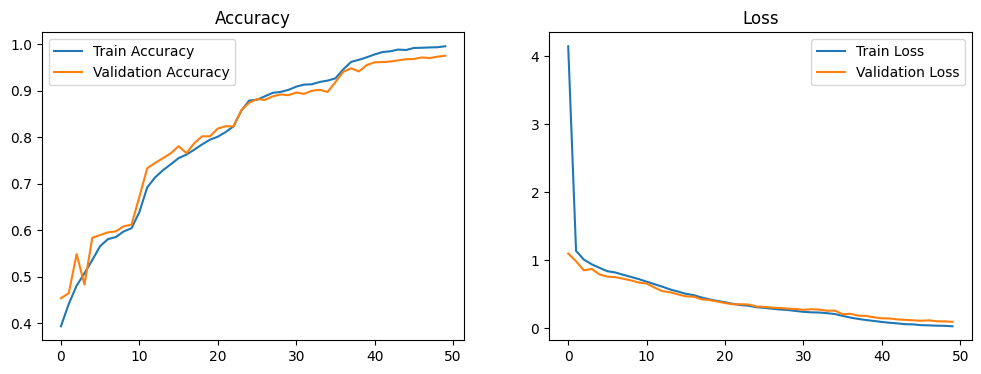

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


**Model Evaluation**

151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.95      0.97      0.96       586
 Moderate_Demented       0.99      1.00      0.99       626
      Non_Demented       0.99      1.00      1.00       588
Very_Mild_Demented       0.97      0.93      0.95       602

          accuracy                           0.98      2402
         macro avg       0.97      0.97      0.97      2402
      weighted avg       0.98      0.98      0.97      2402



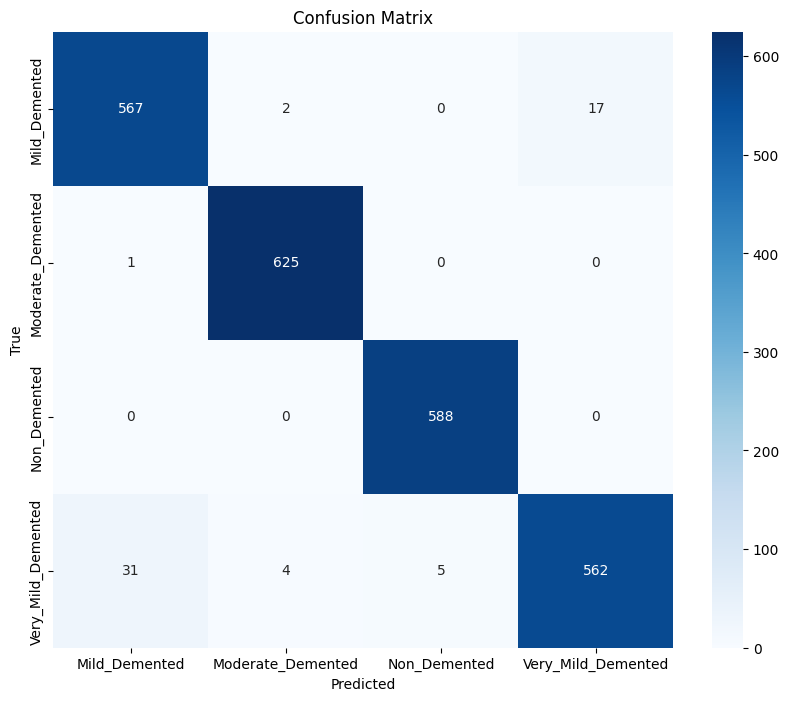

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# VGG16

In [ ]:
from tensorflow.keras.layers import Flatten
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


x = base_model.output
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 27s 36ms/step - accuracy: 0.5520 - loss: 2.6197 - val_accuracy: 0.8193 - val_loss: 0.6040
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.8770 - loss: 0.3926 - val_accuracy: 0.9001 - val_loss: 0.2835
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9298 - loss: 0.1956 - val_accuracy: 0.9292 - val_loss: 0.2130
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.9519 - loss: 0.1337 - val_accuracy: 0.9421 - val_loss: 0.1595
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.9728 - loss: 0.0764 - val_accuracy: 0.9450 - val_loss: 0.1528
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9745 - loss: 0.0666 - val_accuracy: 0.9022 - val_loss: 0.3139
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 20s 32ms/step - accuracy: 0.9834 - loss: 0.0547 - val_accuracy: 0.9621 - val_loss: 0.1098
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.9888 - loss: 0.0347 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9782 - loss: 0.0772
Test Loss: 0.07138612866401672
Test Accuracy: 0.9804329872131348


**Training and validation accuracy and loss curve**

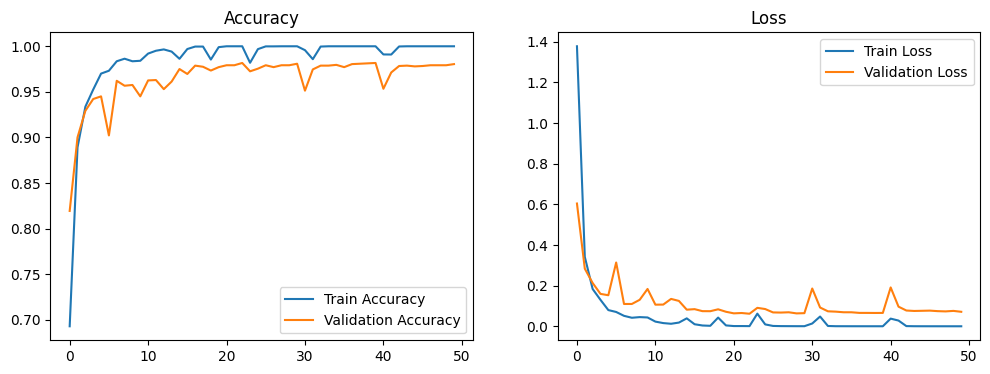

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


**Model Evaluation**

151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.97      0.97      0.97       586
 Moderate_Demented       1.00      1.00      1.00       626
      Non_Demented       0.98      0.99      0.99       588
Very_Mild_Demented       0.97      0.96      0.96       602

          accuracy                           0.98      2402
         macro avg       0.98      0.98      0.98      2402
      weighted avg       0.98      0.98      0.98      2402



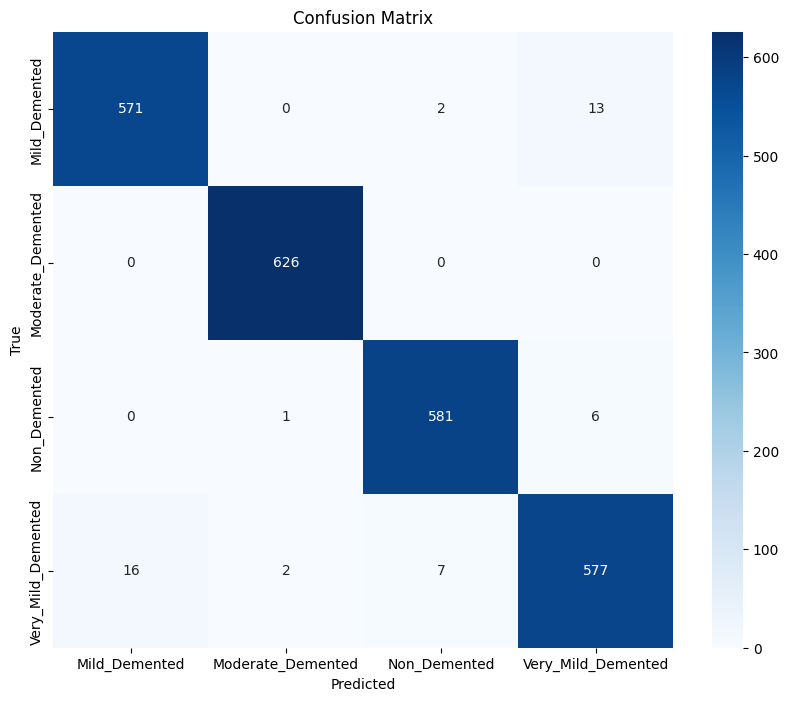

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# VGG19

In [ ]:
from tensorflow.keras.layers import Flatten
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


x = base_model.output
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 32s 49ms/step - accuracy: 0.3384 - loss: 3.5820 - val_accuracy: 0.5758 - val_loss: 1.2481
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.6080 - loss: 1.1249 - val_accuracy: 0.6732 - val_loss: 0.8904
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.7036 - loss: 0.8117 - val_accuracy: 0.7331 - val_loss: 0.7084
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.7669 - loss: 0.6293 - val_accuracy: 0.7835 - val_loss: 0.5937
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.8057 - loss: 0.5054 - val_accuracy: 0.8043 - val_loss: 0.5023
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.8462 - loss: 0.4072 - val_accuracy: 0.8389 - val_loss: 0.4322
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.8719 - loss: 0.3390 - val_accuracy: 0.8547 - val_loss: 0.4000
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.8956 - loss: 0.2845 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9674 - loss: 0.0883
Test Loss: 0.08433953672647476
Test Accuracy: 0.9708576202392578


**Training and validation accuracy and loss curve**

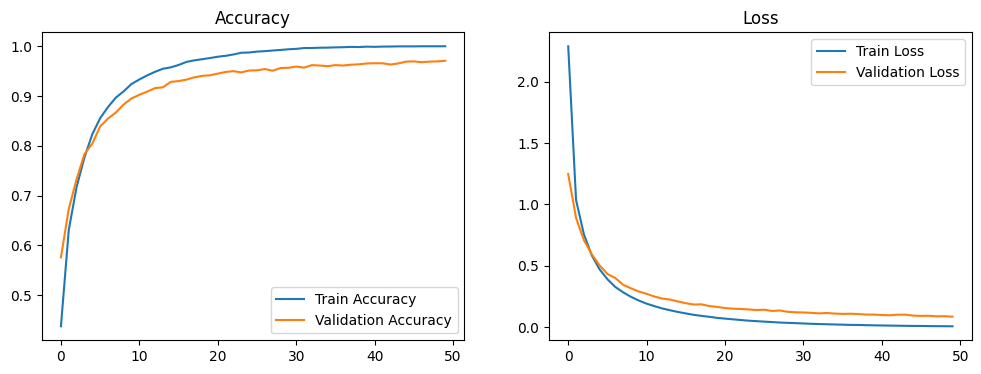

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


**Model Evaluation**

151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.97      0.95      0.96       584
 Moderate_Demented       0.99      1.00      0.99       585
      Non_Demented       0.97      0.99      0.98       618
Very_Mild_Demented       0.96      0.94      0.95       615

          accuracy                           0.97      2402
         macro avg       0.97      0.97      0.97      2402
      weighted avg       0.97      0.97      0.97      2402



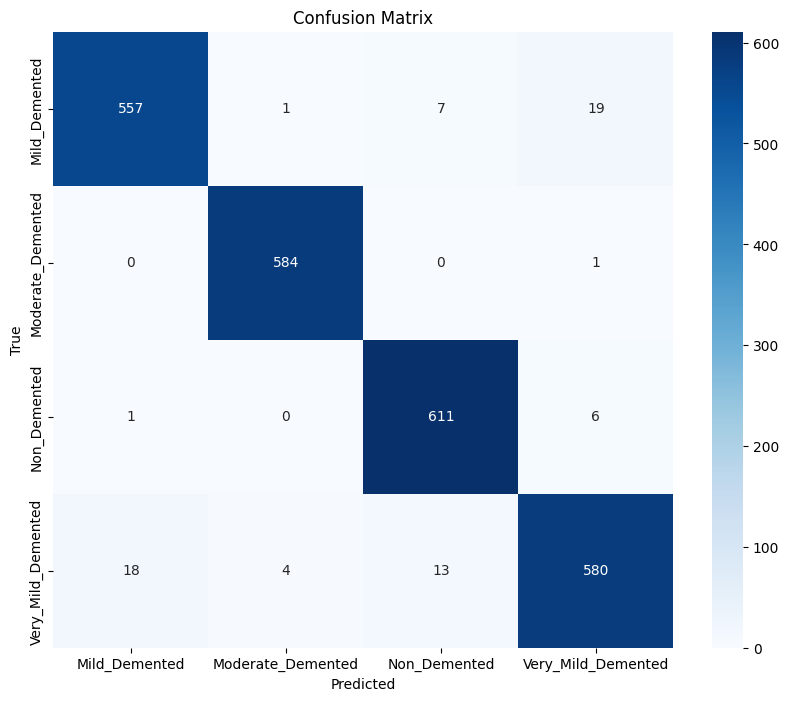

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# MobileNet

In [ ]:

pretrained_model = MobileNet(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
#x =Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.3456 - loss: 1.3940 - val_accuracy: 0.5820 - val_loss: 1.1346
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.5901 - loss: 1.0750 - val_accuracy: 0.6495 - val_loss: 0.9551
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.6482 - loss: 0.9242 - val_accuracy: 0.6903 - val_loss: 0.8467
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - accuracy: 0.6700 - loss: 0.8278 - val_accuracy: 0.7040 - val_loss: 0.7771
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6994 - loss: 0.7614 - val_accuracy: 0.7098 - val_loss: 0.7246
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.7226 - loss: 0.7063 - val_accuracy: 0.7190 - val_loss: 0.6874
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 14ms/step - accuracy: 0.7247 - loss: 0.6772 - val_accuracy: 0.7294 - val_loss: 0.6565
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.7292 - loss: 0.6509 - v

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8342 - loss: 0.3887
Test Loss: 0.38345593214035034
Test Accuracy: 0.8372189998626709


**Training and validation accuracy and loss curve**

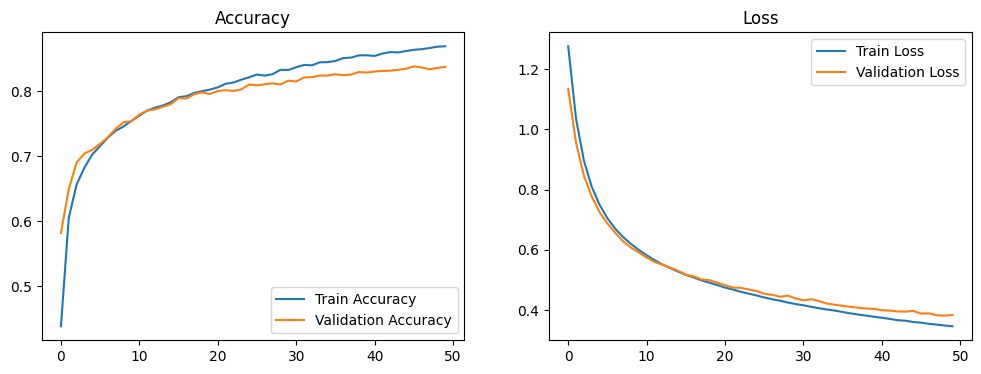

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


**Model Evaluation**

151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.83      0.74      0.78       584
 Moderate_Demented       0.72      0.78      0.75       585
      Non_Demented       1.00      1.00      1.00       618
Very_Mild_Demented       0.81      0.82      0.81       615

          accuracy                           0.84      2402
         macro avg       0.84      0.84      0.84      2402
      weighted avg       0.84      0.84      0.84      2402



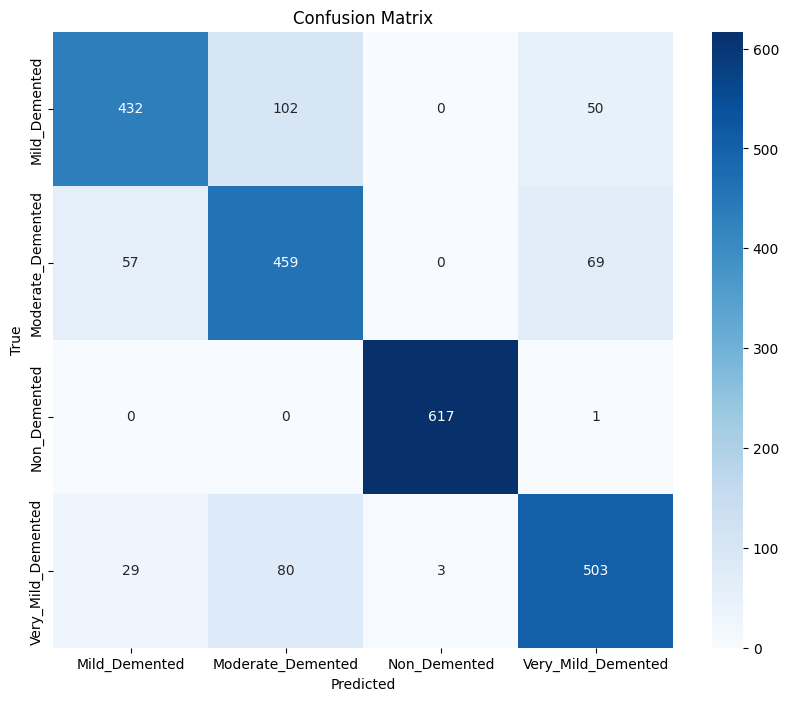

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# MobileNet V2

In [ ]:

pretrained_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
#x = Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 29s 36ms/step - accuracy: 0.3254 - loss: 1.5028 - val_accuracy: 0.5575 - val_loss: 1.1463
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 27s 16ms/step - accuracy: 0.5818 - loss: 1.0948 - val_accuracy: 0.6307 - val_loss: 0.9853
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6280 - loss: 0.9601 - val_accuracy: 0.6615 - val_loss: 0.8823
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - accuracy: 0.6674 - loss: 0.8639 - val_accuracy: 0.6724 - val_loss: 0.8044
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.6825 - loss: 0.7874 - val_accuracy: 0.6799 - val_loss: 0.7520
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.6936 - loss: 0.7428 - val_accuracy: 0.6953 - val_loss: 0.7148
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.6990 - loss: 0.7125 - val_accuracy: 0.7040 - val_loss: 0.6890
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.7029 - loss: 0.6915 - v

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7968 - loss: 0.4709
Test Loss: 0.47472479939460754
Test Accuracy: 0.8022481203079224


**Training and validation accuracy and loss curve**

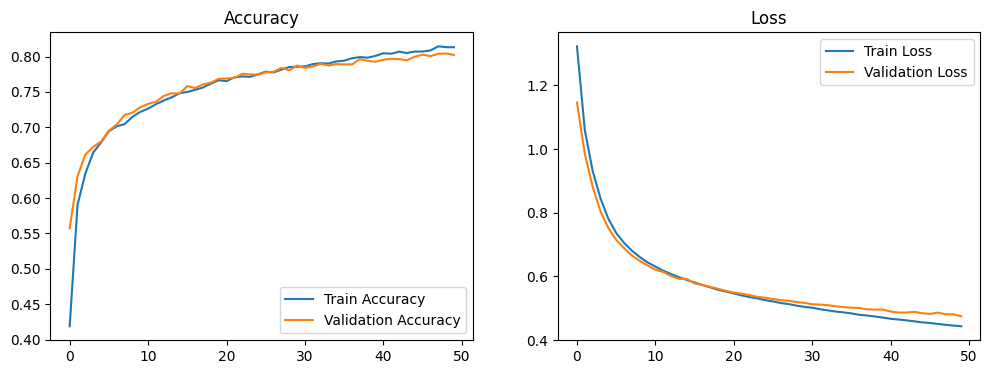

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


**Model Evaluation**

151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.68      0.77      0.72       584
 Moderate_Demented       0.74      0.64      0.69       585
      Non_Demented       0.99      1.00      0.99       618
Very_Mild_Demented       0.78      0.80      0.79       615

          accuracy                           0.80      2402
         macro avg       0.80      0.80      0.80      2402
      weighted avg       0.80      0.80      0.80      2402



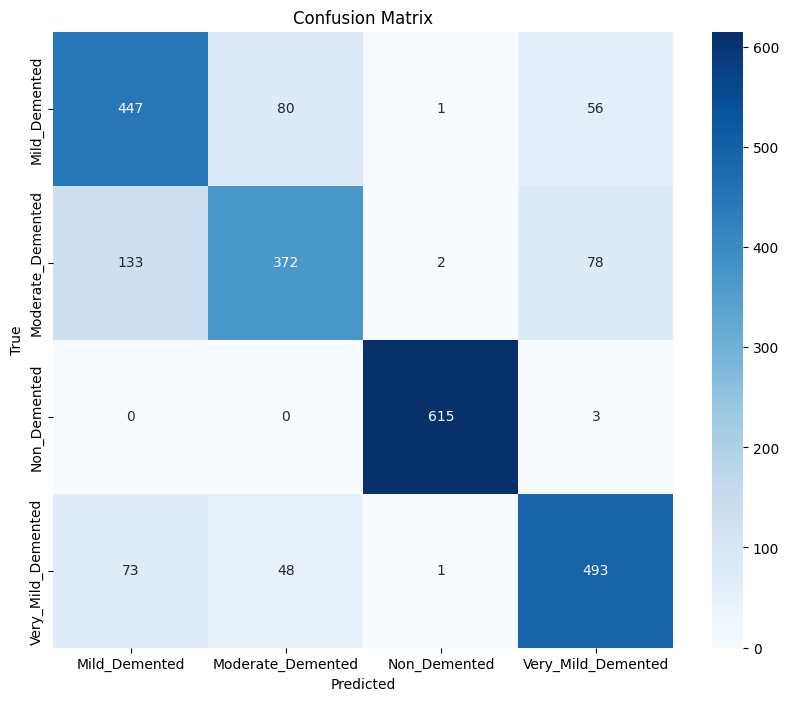

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# ResNet101

In [ ]:

pretrained_model = ResNet101(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
#x=Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 61s 69ms/step - accuracy: 0.3644 - loss: 1.3540 - val_accuracy: 0.6203 - val_loss: 0.9233
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 70s 55ms/step - accuracy: 0.6656 - loss: 0.8537 - val_accuracy: 0.7252 - val_loss: 0.7298
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 36s 46ms/step - accuracy: 0.7479 - loss: 0.6884 - val_accuracy: 0.7635 - val_loss: 0.6282
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.7832 - loss: 0.6016 - val_accuracy: 0.8014 - val_loss: 0.5596
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 28s 47ms/step - accuracy: 0.8079 - loss: 0.5334 - val_accuracy: 0.8193 - val_loss: 0.5014
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.8316 - loss: 0.4813 - val_accuracy: 0.8318 - val_loss: 0.4645
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.8575 - loss: 0.4350 - val_accuracy: 0.8530 - val_loss: 0.4198
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 42s 47ms/step - accuracy: 0.8695 - loss: 0.3999 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.9687 - loss: 0.1044
Test Loss: 0.1037450060248375
Test Accuracy: 0.9658617973327637


**Training and validation accuracy and loss curve**

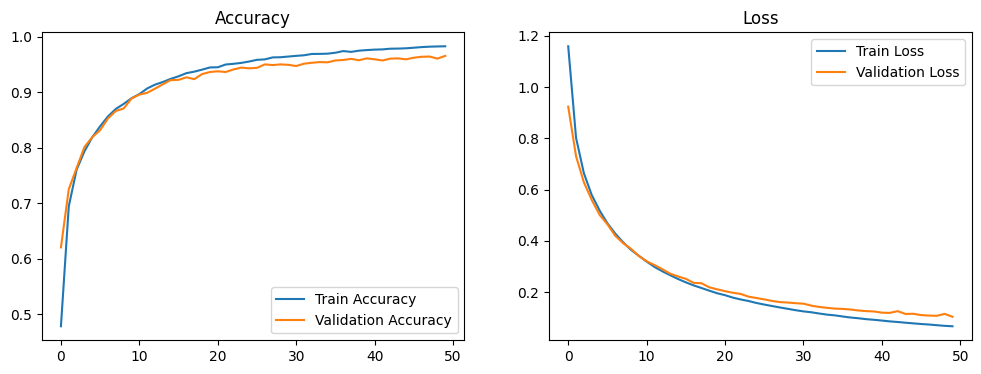

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


**Model Evaluation**

151/151 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.93      0.95      0.94       584
 Moderate_Demented       0.99      1.00      0.99       585
      Non_Demented       0.99      0.99      0.99       618
Very_Mild_Demented       0.95      0.93      0.94       615

          accuracy                           0.97      2402
         macro avg       0.97      0.97      0.97      2402
      weighted avg       0.97      0.97      0.97      2402



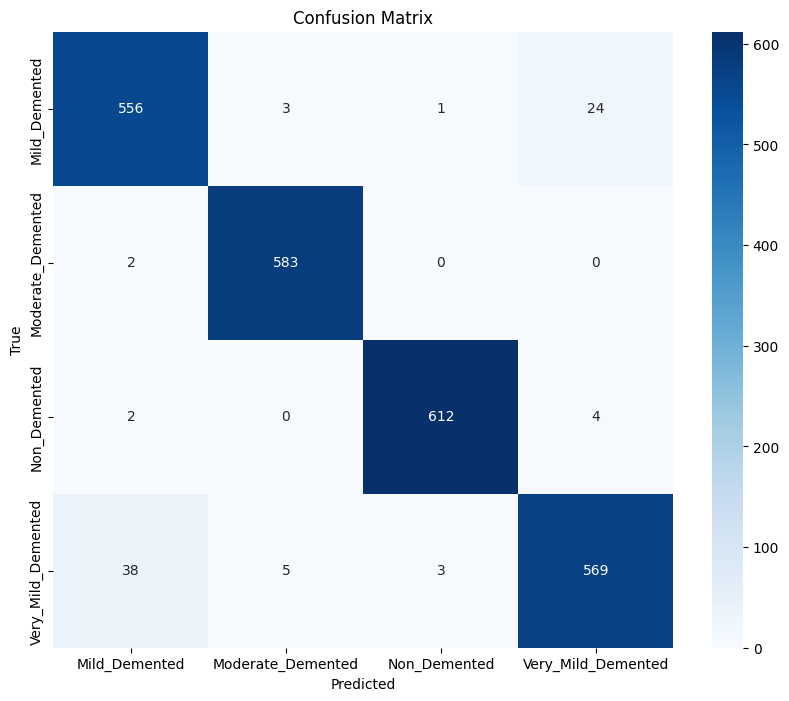

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# ResNet152

In [ ]:

pretrained_model = ResNet152(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
inputs = pretrained_model.input
x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)
#x=Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 88s 101ms/step - accuracy: 0.3763 - loss: 1.3583 - val_accuracy: 0.6603 - val_loss: 0.8950
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.6956 - loss: 0.8299 - val_accuracy: 0.7394 - val_loss: 0.7028
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 82s 69ms/step - accuracy: 0.7590 - loss: 0.6730 - val_accuracy: 0.7827 - val_loss: 0.6055
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.8040 - loss: 0.5819 - val_accuracy: 0.8118 - val_loss: 0.5363
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.8227 - loss: 0.5160 - val_accuracy: 0.8289 - val_loss: 0.4902
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.8438 - loss: 0.4644 - val_accuracy: 0.8418 - val_loss: 0.4464
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 83s 70ms/step - accuracy: 0.8623 - loss: 0.4211 - val_accuracy: 0.8651 - val_loss: 0.4063
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 41s 68ms/step - accuracy: 0.8715 - loss: 0.3863 -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.9668 - loss: 0.0987
Test Loss: 0.09625744819641113
Test Accuracy: 0.9679433703422546


**Training and validation accuracy and loss curve**

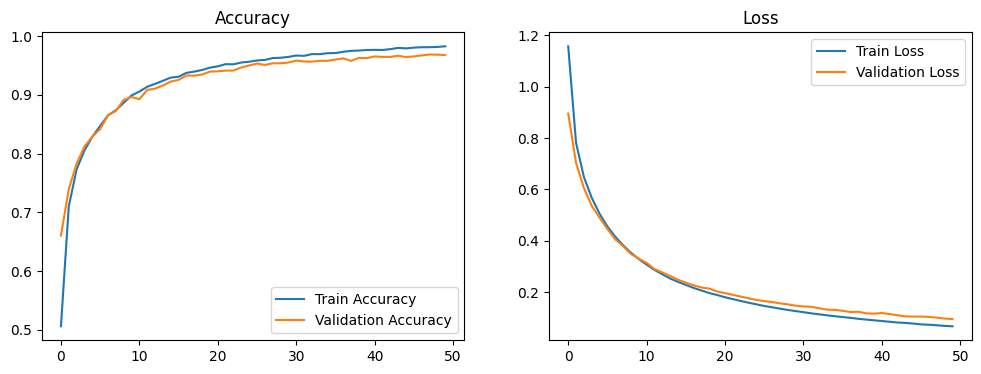

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


**Model Evaluation**

151/151 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.95      0.94      0.95       584
 Moderate_Demented       0.98      0.99      0.99       585
      Non_Demented       0.99      1.00      0.99       618
Very_Mild_Demented       0.95      0.94      0.95       615

          accuracy                           0.97      2402
         macro avg       0.97      0.97      0.97      2402
      weighted avg       0.97      0.97      0.97      2402



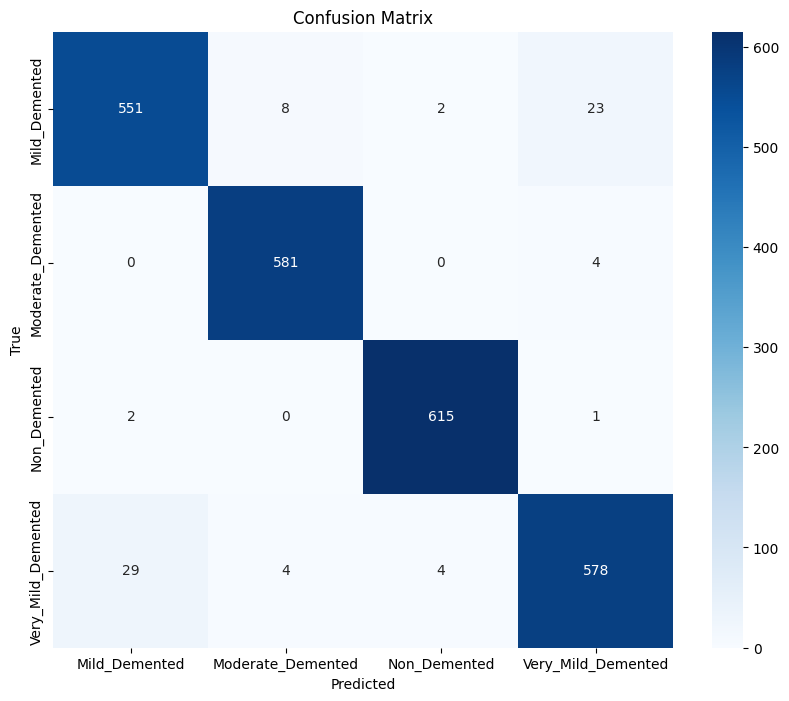

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# Inception V3

In [ ]:

pretrained_model = InceptionV3(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = pretrained_model.input
x = Dense(512, activation='relu')(pretrained_model.output)
x = Dense(256, activation='relu')(x)
#x=Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step - accuracy: 0.3918 - loss: 11.9493 - val_accuracy: 0.5616 - val_loss: 2.8306
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 16s 26ms/step - accuracy: 0.5973 - loss: 2.4352 - val_accuracy: 0.6278 - val_loss: 1.9785
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 19s 24ms/step - accuracy: 0.6696 - loss: 1.6337 - val_accuracy: 0.6524 - val_loss: 1.7103
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.7006 - loss: 1.3563 - val_accuracy: 0.6982 - val_loss: 1.3357
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.7571 - loss: 1.0526 - val_accuracy: 0.7244 - val_loss: 1.2204
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.7703 - loss: 0.9009 - val_accuracy: 0.7448 - val_loss: 1.1161
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.7908 - loss: 0.8166 - val_accuracy: 0.7398 - val_loss: 1.0196
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 14s 24ms/step - accuracy: 0.8121 - loss: 0.6741 -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8825 - loss: 0.4306
Test Loss: 0.45956137776374817
Test Accuracy: 0.8863447308540344


**Training and validation accuracy and loss curve**

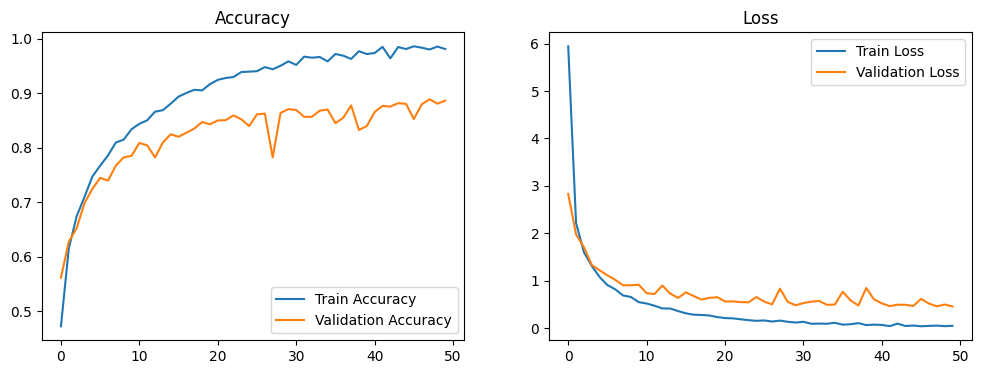

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


**Model Evaluation**

151/151 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.88      0.86      0.87       584
 Moderate_Demented       0.95      0.87      0.91       585
      Non_Demented       0.92      0.94      0.93       618
Very_Mild_Demented       0.81      0.88      0.84       615

          accuracy                           0.89      2402
         macro avg       0.89      0.89      0.89      2402
      weighted avg       0.89      0.89      0.89      2402



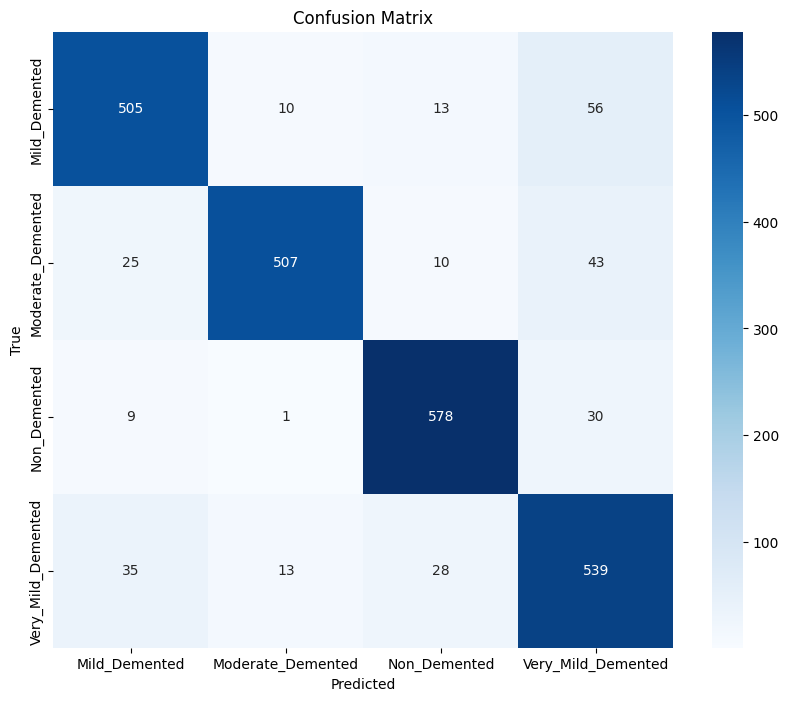

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# DenseNet121

In [ ]:

pretrained_model = DenseNet121(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = pretrained_model.input
x = Dense(512, activation='relu')(pretrained_model.output)
x = Dense(256, activation='relu')(x)
#x=Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 68s 72ms/step - accuracy: 0.4567 - loss: 1.3946 - val_accuracy: 0.7177 - val_loss: 0.6986
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 45s 29ms/step - accuracy: 0.7401 - loss: 0.6417 - val_accuracy: 0.8072 - val_loss: 0.5268
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.8158 - loss: 0.4933 - val_accuracy: 0.8310 - val_loss: 0.4525
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - accuracy: 0.8567 - loss: 0.4127 - val_accuracy: 0.8543 - val_loss: 0.3982
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.8723 - loss: 0.3628 - val_accuracy: 0.8701 - val_loss: 0.3609
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - accuracy: 0.8927 - loss: 0.3277 - val_accuracy: 0.8801 - val_loss: 0.3300
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - accuracy: 0.8903 - loss: 0.3023 - val_accuracy: 0.8893 - val_loss: 0.3087
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - accuracy: 0.9084 - loss: 0.2781 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9596 - loss: 0.1040
Test Loss: 0.1148327961564064
Test Accuracy: 0.9558700919151306


**Training and validation accuracy and loss curve**

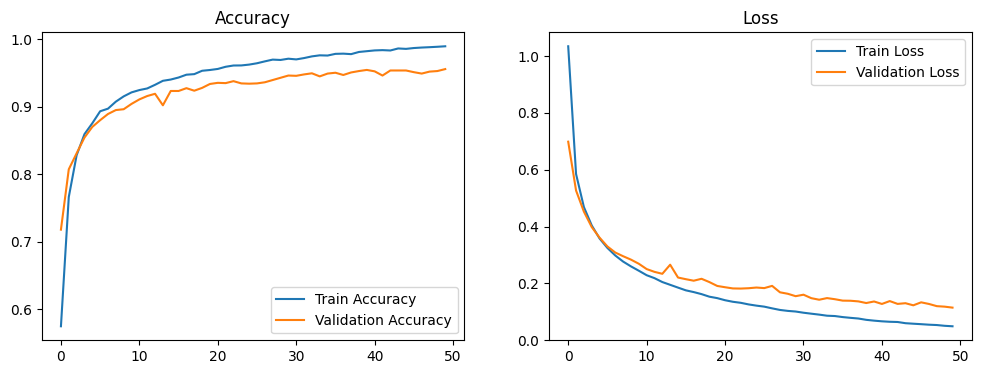

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


**Model Evaluation**

151/151 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.93      0.95      0.94       584
 Moderate_Demented       0.97      0.98      0.97       585
      Non_Demented       0.99      0.99      0.99       618
Very_Mild_Demented       0.93      0.91      0.92       615

          accuracy                           0.96      2402
         macro avg       0.96      0.96      0.96      2402
      weighted avg       0.96      0.96      0.96      2402



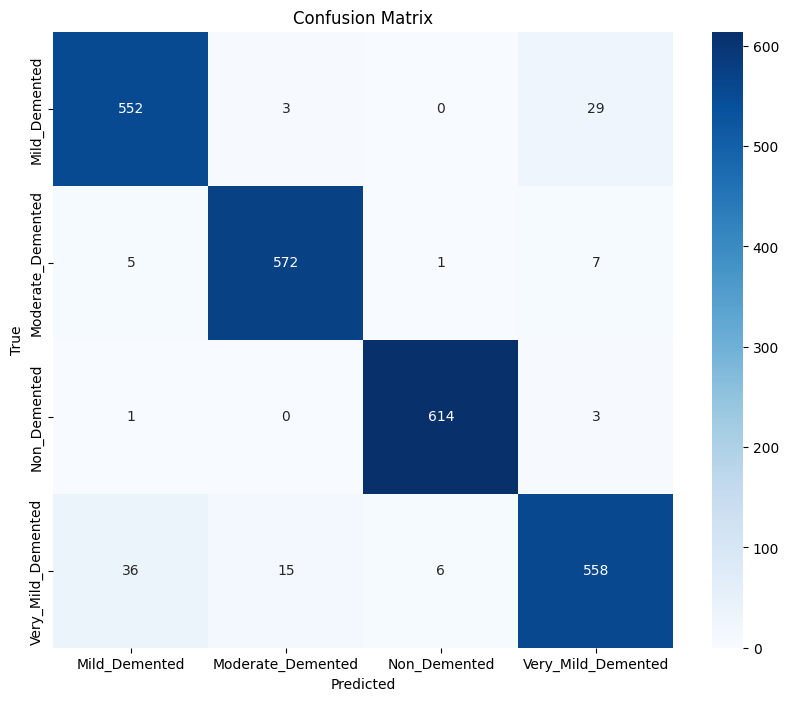

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# DenseNet169

In [ ]:

pretrained_model = DenseNet169(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = pretrained_model.input
x = Dense(512, activation='relu')(pretrained_model.output)
x = Dense(256, activation='relu')(x)
#x=Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 86s 91ms/step - accuracy: 0.4580 - loss: 1.9476 - val_accuracy: 0.6811 - val_loss: 0.7172
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.7457 - loss: 0.6265 - val_accuracy: 0.7660 - val_loss: 0.5681
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.7994 - loss: 0.4979 - val_accuracy: 0.8264 - val_loss: 0.4594
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.8296 - loss: 0.4419 - val_accuracy: 0.8247 - val_loss: 0.4271
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8544 - loss: 0.3856 - val_accuracy: 0.8597 - val_loss: 0.3723
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.8797 - loss: 0.3411 - val_accuracy: 0.8759 - val_loss: 0.3382
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.8882 - loss: 0.3132 - val_accuracy: 0.8822 - val_loss: 0.3170
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.9035 - loss: 0.2951 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9567 - loss: 0.1161
Test Loss: 0.10752008855342865
Test Accuracy: 0.9608659744262695


**Training and validation accuracy and loss curve**

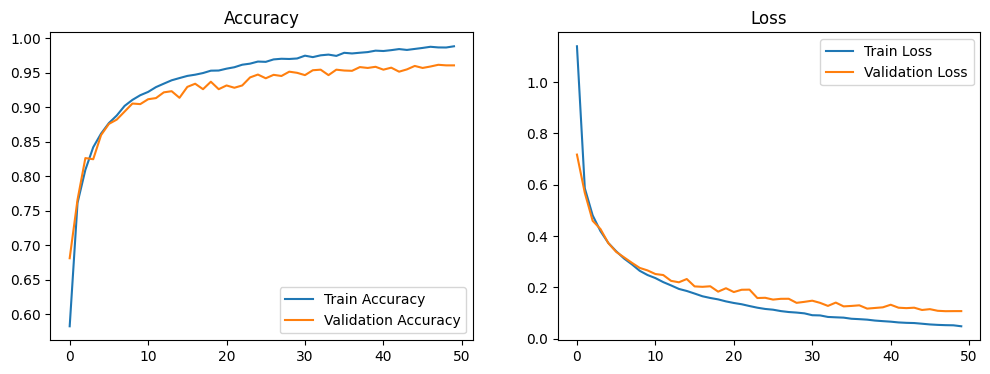

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


**Model Evaluation**

151/151 ━━━━━━━━━━━━━━━━━━━━ 32s 105ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.94      0.92      0.93       584
 Moderate_Demented       0.96      1.00      0.98       585
      Non_Demented       1.00      1.00      1.00       618
Very_Mild_Demented       0.94      0.93      0.94       615

          accuracy                           0.96      2402
         macro avg       0.96      0.96      0.96      2402
      weighted avg       0.96      0.96      0.96      2402



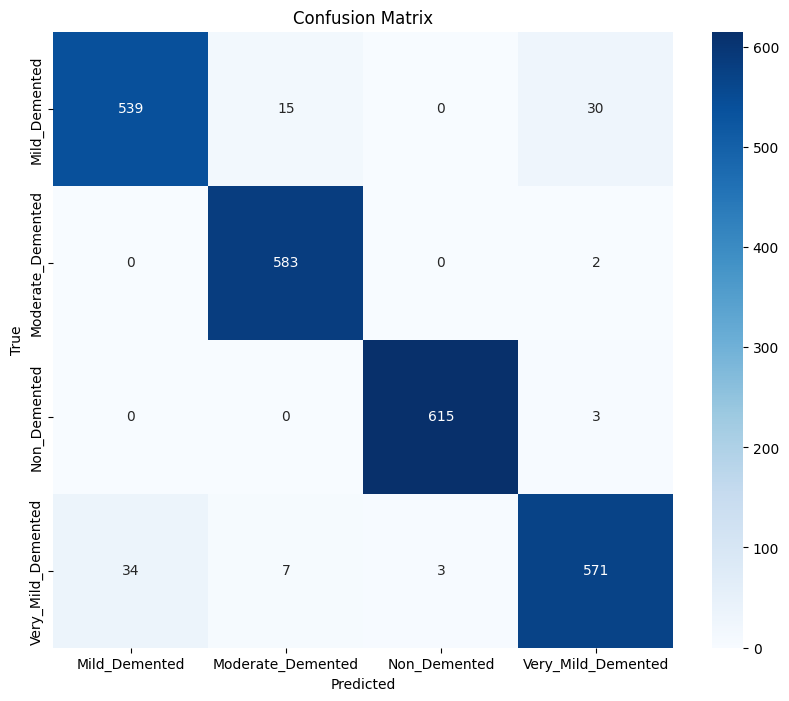

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# DenseNet 201

In [ ]:

pretrained_model = DenseNet201(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = pretrained_model.input
x = Dense(512, activation='relu')(pretrained_model.output)
x = Dense(256, activation='relu')(x)
#x=Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 96s 102ms/step - accuracy: 0.5396 - loss: 1.1892 - val_accuracy: 0.7552 - val_loss: 0.5883
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 24s 39ms/step - accuracy: 0.7915 - loss: 0.5240 - val_accuracy: 0.8339 - val_loss: 0.4270
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8488 - loss: 0.3999 - val_accuracy: 0.8672 - val_loss: 0.3644
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.8737 - loss: 0.3464 - val_accuracy: 0.8759 - val_loss: 0.3285
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.8954 - loss: 0.2986 - val_accuracy: 0.9013 - val_loss: 0.2864
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.9095 - loss: 0.2587 - val_accuracy: 0.9097 - val_loss: 0.2652
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.9232 - loss: 0.2408 - val_accuracy: 0.9126 - val_loss: 0.2459
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 25s 41ms/step - accuracy: 0.9276 - loss: 0.2181 -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.9693 - loss: 0.0744
Test Loss: 0.07116912305355072
Test Accuracy: 0.9712739586830139


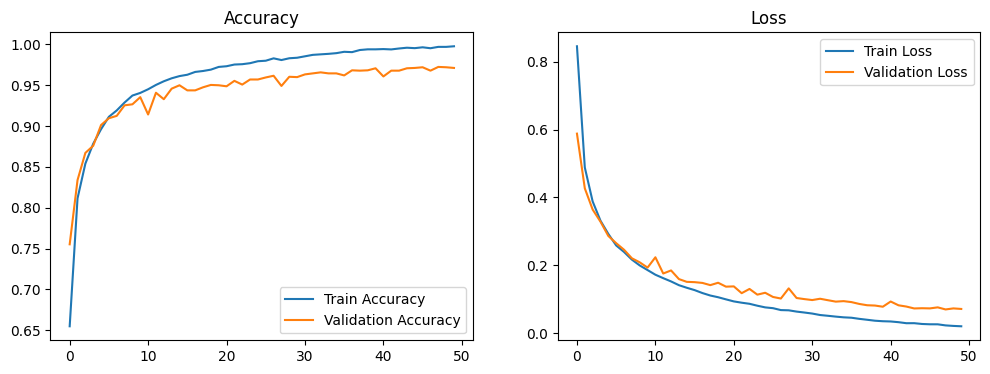

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


151/151 ━━━━━━━━━━━━━━━━━━━━ 29s 109ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.94      0.97      0.95       583
 Moderate_Demented       0.98      0.99      0.98       597
      Non_Demented       1.00      1.00      1.00       623
Very_Mild_Demented       0.97      0.93      0.95       599

          accuracy                           0.97      2402
         macro avg       0.97      0.97      0.97      2402
      weighted avg       0.97      0.97      0.97      2402



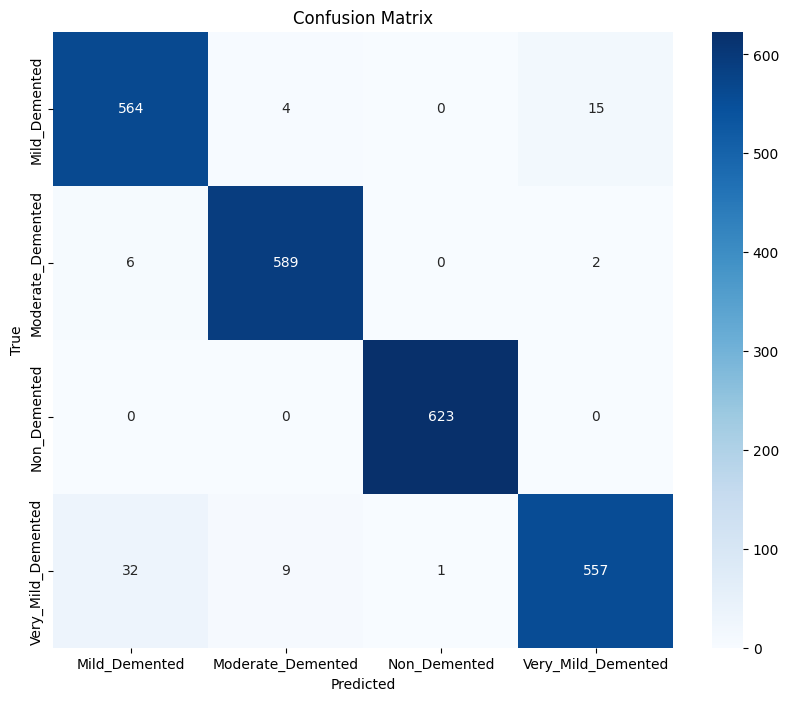

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# Xception

In [ ]:

pretrained_model = Xception(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
inputs = pretrained_model.input
x = Dense(512, activation='relu')(pretrained_model.output)
x = Dense(256, activation='relu')(x)
#x=Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 34s 42ms/step - accuracy: 0.3717 - loss: 1.8339 - val_accuracy: 0.5745 - val_loss: 1.0042
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.5987 - loss: 0.9428 - val_accuracy: 0.6403 - val_loss: 0.8465
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.6735 - loss: 0.7811 - val_accuracy: 0.6915 - val_loss: 0.7423
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.7191 - loss: 0.6789 - val_accuracy: 0.7319 - val_loss: 0.6771
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7538 - loss: 0.6204 - val_accuracy: 0.7540 - val_loss: 0.6227
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.7836 - loss: 0.5625 - val_accuracy: 0.7756 - val_loss: 0.5899
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 29ms/step - accuracy: 0.8036 - loss: 0.5232 - val_accuracy: 0.7794 - val_loss: 0.5647
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 18s 30ms/step - accuracy: 0.8217 - loss: 0.4811 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9002 - loss: 0.2638
Test Loss: 0.26352986693382263
Test Accuracy: 0.902164876461029


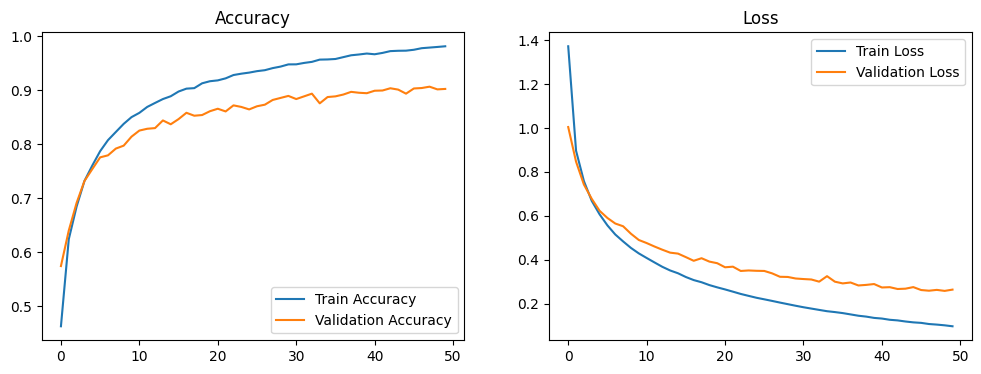

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.93      0.85      0.89       583
 Moderate_Demented       0.89      0.96      0.92       597
      Non_Demented       0.94      0.93      0.94       623
Very_Mild_Demented       0.85      0.87      0.86       599

          accuracy                           0.90      2402
         macro avg       0.90      0.90      0.90      2402
      weighted avg       0.90      0.90      0.90      2402



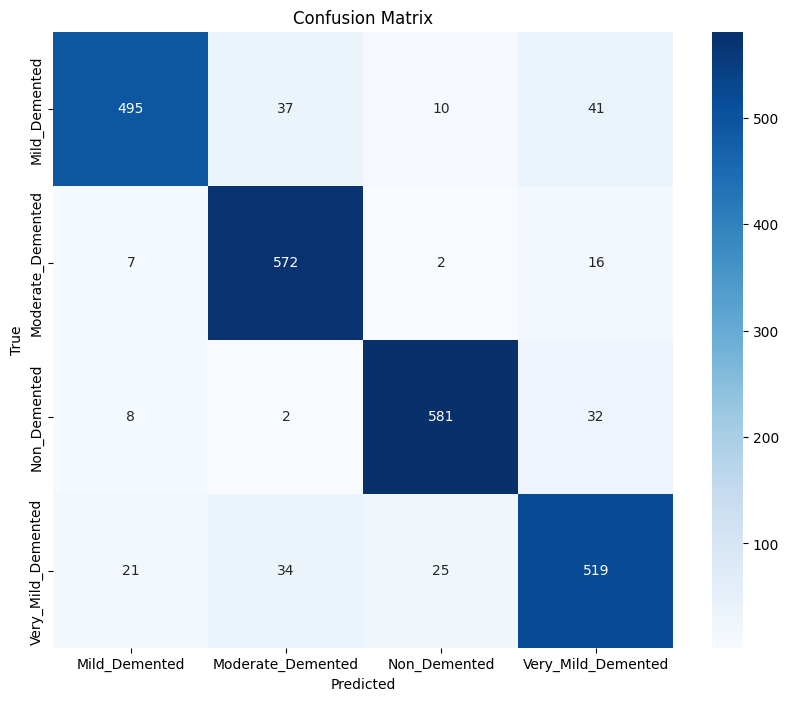

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# NasNet Large

In [ ]:

pretrained_model = NASNetLarge(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input
x = Dense(512, activation='relu')(pretrained_model.output)
x = Dense(256, activation='relu')(x)
#x=Dropout(0.4)(x)
outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=pretrained_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 123s 146ms/step - accuracy: 0.5165 - loss: 1.1269 - val_accuracy: 0.6440 - val_loss: 0.7600
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 60s 100ms/step - accuracy: 0.6661 - loss: 0.7720 - val_accuracy: 0.6532 - val_loss: 0.7452
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 59s 99ms/step - accuracy: 0.7171 - loss: 0.6621 - val_accuracy: 0.7298 - val_loss: 0.6453
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 59s 98ms/step - accuracy: 0.7437 - loss: 0.6027 - val_accuracy: 0.7311 - val_loss: 0.6207
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 59s 98ms/step - accuracy: 0.7434 - loss: 0.6005 - val_accuracy: 0.7798 - val_loss: 0.5267
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 59s 98ms/step - accuracy: 0.7748 - loss: 0.5458 - val_accuracy: 0.8110 - val_loss: 0.4818
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 59s 98ms/step - accuracy: 0.7737 - loss: 0.5288 - val_accuracy: 0.7706 - val_loss: 0.5404
Epoch 8/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 59s 98ms/step - accuracy: 0.7930 - loss: 0.5027

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.8901 - loss: 0.2840
Test Loss: 0.27044960856437683
Test Accuracy: 0.8955037593841553


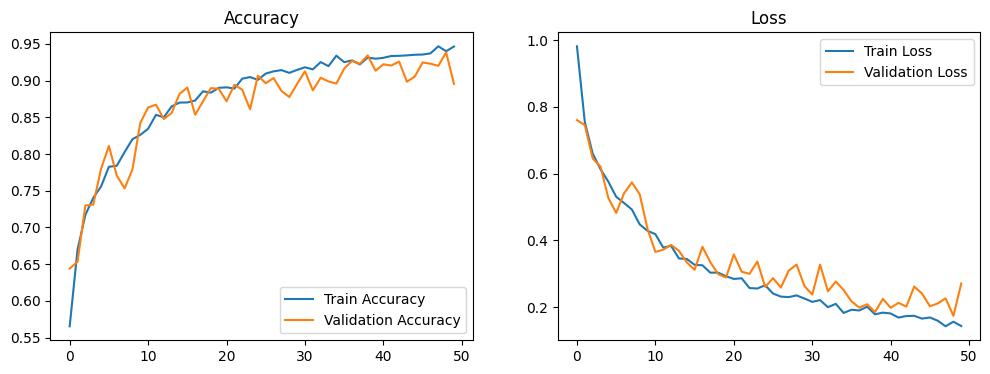

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


151/151 ━━━━━━━━━━━━━━━━━━━━ 36s 158ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.95      0.76      0.84       583
 Moderate_Demented       0.83      0.98      0.90       597
      Non_Demented       0.95      1.00      0.97       623
Very_Mild_Demented       0.87      0.84      0.86       599

          accuracy                           0.90      2402
         macro avg       0.90      0.89      0.89      2402
      weighted avg       0.90      0.90      0.89      2402



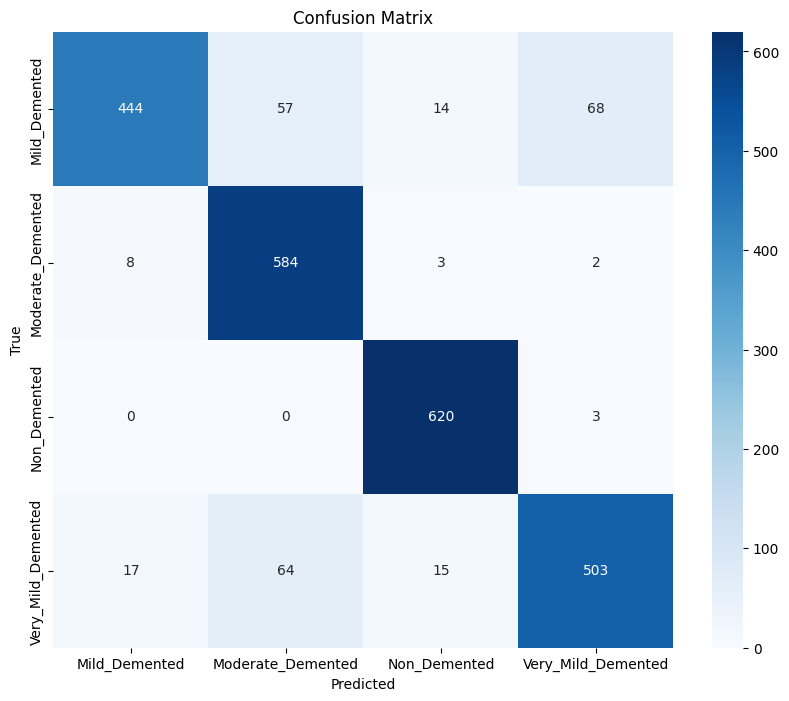

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# VGG16_MobileNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



#VGG16
vgg = VGG16(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
vgg.trainable = False


#MobileNet
mobilenet = MobileNet(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
mobilenet.trainable = False


input_layer = Input(shape=(128, 128, 3))
vgg_features = vgg(input_layer)
mobilenet_features = mobilenet(input_layer)


# Concatenate features
merged_features = Concatenate()([vgg_features,mobilenet_features])
x = Dense(256, activation='relu')(merged_features)
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25
)


Epoch 1/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 34s 46ms/step - accuracy: 0.3689 - loss: 1.5708 - val_accuracy: 0.6470 - val_loss: 0.8399
Epoch 2/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.7142 - loss: 0.7345 - val_accuracy: 0.7781 - val_loss: 0.5934
Epoch 3/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.8158 - loss: 0.5317 - val_accuracy: 0.8376 - val_loss: 0.4609
Epoch 4/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.8604 - loss: 0.4222 - val_accuracy: 0.8605 - val_loss: 0.3846
Epoch 5/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.8868 - loss: 0.3544 - val_accuracy: 0.8955 - val_loss: 0.3267
Epoch 6/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.9147 - loss: 0.2895 - val_accuracy: 0.9147 - val_loss: 0.2836
Epoch 7/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.9294 - loss: 0.2512 - val_accuracy: 0.9242 - val_loss: 0.2516
Epoch 8/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.9340 - loss: 0.2307 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9709 - loss: 0.0891
Test Loss: 0.08753533661365509
Test Accuracy: 0.973771870136261


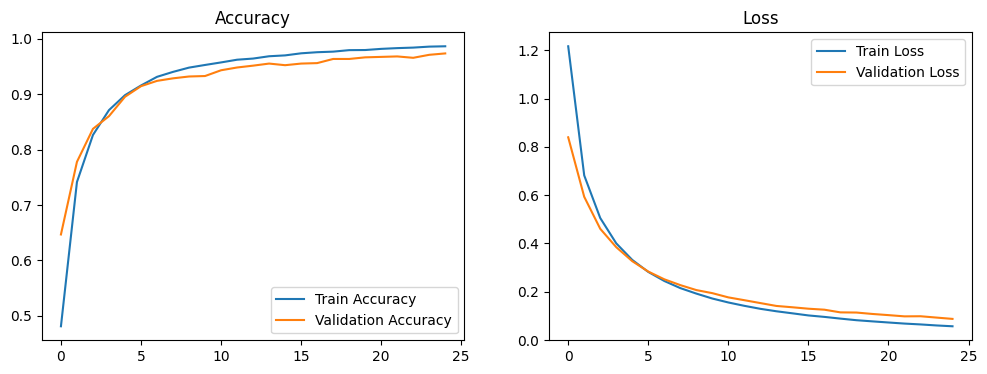

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


151/151 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.94      0.96      0.95       571
 Moderate_Demented       0.99      0.99      0.99       587
      Non_Demented       1.00      1.00      1.00       656
Very_Mild_Demented       0.96      0.94      0.95       588

          accuracy                           0.97      2402
         macro avg       0.97      0.97      0.97      2402
      weighted avg       0.97      0.97      0.97      2402



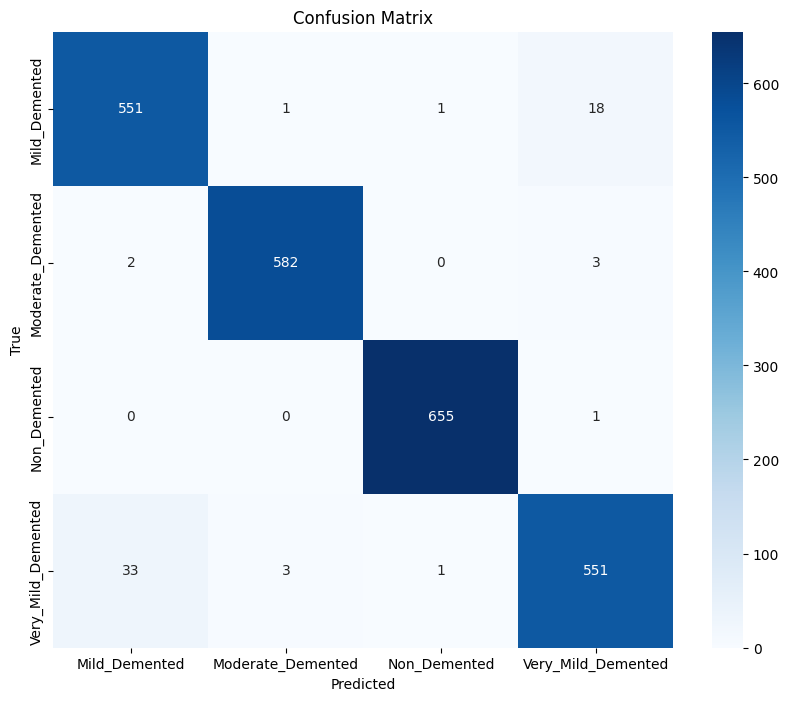

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# VGG16_Resnet152

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152, VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



#VGG16
vgg = VGG16(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
vgg.trainable = False


#ResNet152
resnet = ResNet152(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
resnet.trainable = False

input_layer = Input(shape=(128, 128, 3))
vgg_features = vgg(input_layer)
resnet_features = resnet(input_layer)


# Concatenate features
merged_features = Concatenate()([vgg_features,resnet_features])
x = Dense(256, activation='relu')(merged_features)
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)
model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25)

Epoch 1/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 96s 121ms/step - accuracy: 0.4388 - loss: 1.3317 - val_accuracy: 0.7519 - val_loss: 0.6536
Epoch 2/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 56s 93ms/step - accuracy: 0.7731 - loss: 0.5948 - val_accuracy: 0.8393 - val_loss: 0.4529
Epoch 3/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 55s 91ms/step - accuracy: 0.8612 - loss: 0.4116 - val_accuracy: 0.8843 - val_loss: 0.3492
Epoch 4/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 55s 92ms/step - accuracy: 0.9012 - loss: 0.3171 - val_accuracy: 0.9034 - val_loss: 0.2909
Epoch 5/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 55s 91ms/step - accuracy: 0.9230 - loss: 0.2535 - val_accuracy: 0.9221 - val_loss: 0.2456
Epoch 6/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 55s 92ms/step - accuracy: 0.9345 - loss: 0.2168 - val_accuracy: 0.9280 - val_loss: 0.2176
Epoch 7/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 55s 92ms/step - accuracy: 0.9449 - loss: 0.1890 - val_accuracy: 0.9392 - val_loss: 0.1907
Epoch 8/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 55s 92ms/step - accuracy: 0.9535 - loss: 0.1657 -

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - accuracy: 0.9777 - loss: 0.0708
Test Loss: 0.06548646837472916
Test Accuracy: 0.9796003103256226


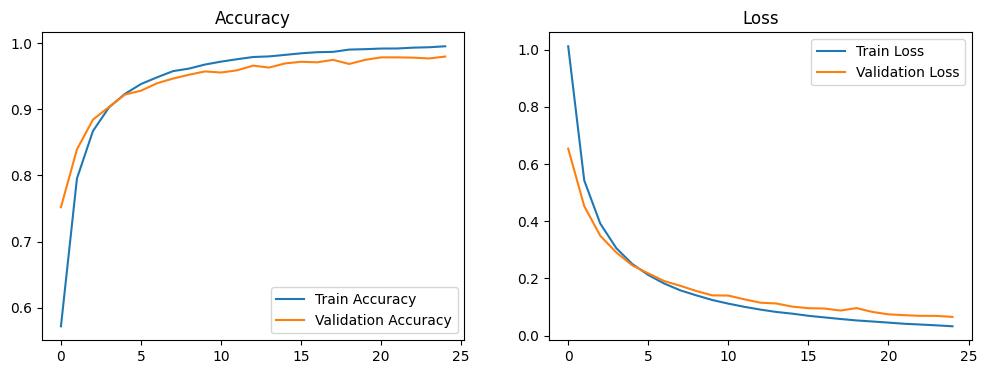

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


151/151 ━━━━━━━━━━━━━━━━━━━━ 26s 120ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.98      0.97       571
 Moderate_Demented       0.99      1.00      1.00       587
      Non_Demented       0.99      0.99      0.99       656
Very_Mild_Demented       0.97      0.95      0.96       588

          accuracy                           0.98      2402
         macro avg       0.98      0.98      0.98      2402
      weighted avg       0.98      0.98      0.98      2402



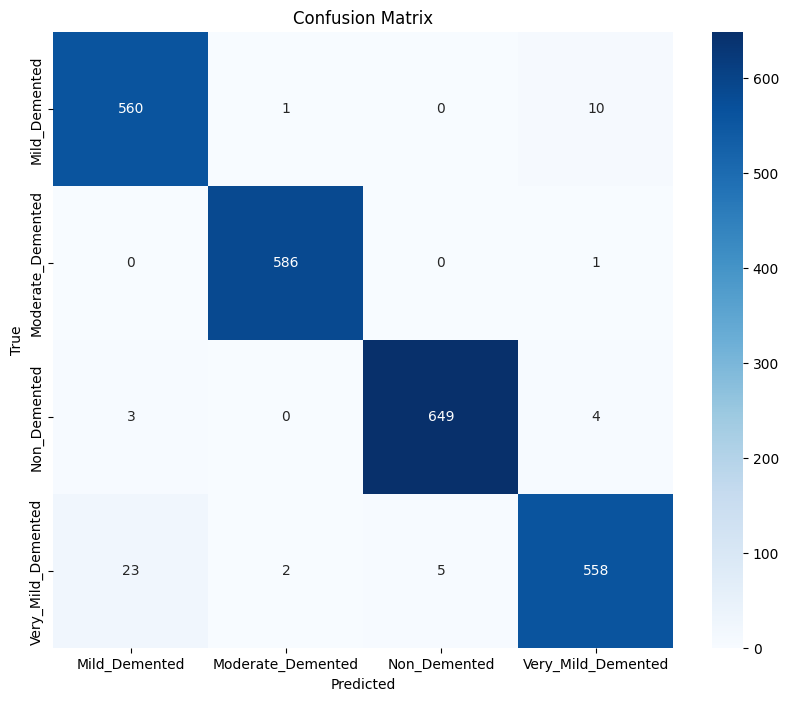

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# VGG16_ResNet101

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet101, VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



#VGG16
vgg = VGG16(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
vgg.trainable = False


#ResNet101
resnet = ResNet101(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
resnet.trainable = False


input_layer = Input(shape=(128, 128, 3))

vgg_features = vgg(input_layer)
resnet_features = resnet(input_layer)


# Concatenate features
merged_features = Concatenate()([vgg_features,resnet_features])

x = Dense(512, activation='relu')(merged_features)
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='softmax')(x)


model = Model(inputs=input_layer, outputs=x)


model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25
)


Epoch 1/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step - accuracy: 0.5104 - loss: 1.2395 - val_accuracy: 0.7860 - val_loss: 0.5622
Epoch 2/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.8252 - loss: 0.4829 - val_accuracy: 0.8401 - val_loss: 0.4202
Epoch 3/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.8883 - loss: 0.3385 - val_accuracy: 0.8963 - val_loss: 0.3077
Epoch 4/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.9225 - loss: 0.2543 - val_accuracy: 0.9138 - val_loss: 0.2585
Epoch 5/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.9451 - loss: 0.2011 - val_accuracy: 0.9172 - val_loss: 0.2368
Epoch 6/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.9524 - loss: 0.1752 - val_accuracy: 0.9355 - val_loss: 0.1946
Epoch 7/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.9666 - loss: 0.1422 - val_accuracy: 0.9438 - val_loss: 0.1757
Epoch 8/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 46s 76ms/step - accuracy: 0.9730 - loss: 0.1193 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 9s 60ms/step - accuracy: 0.9768 - loss: 0.0666
Test Loss: 0.06857605278491974
Test Accuracy: 0.973771870136261


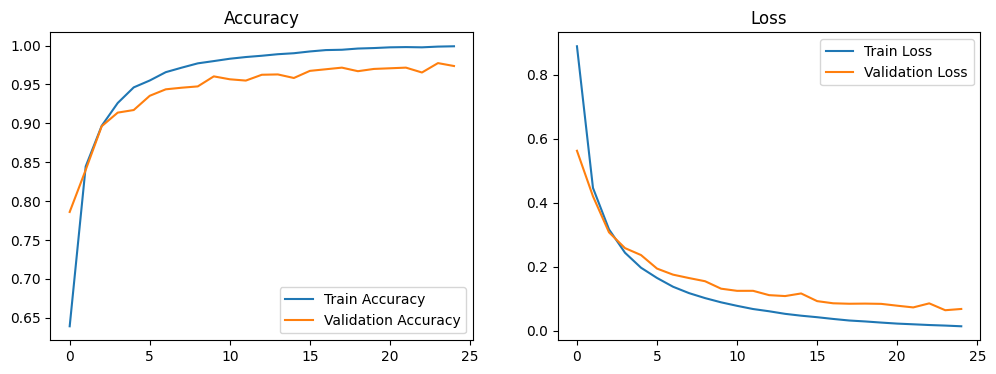

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


151/151 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.98      0.97       610
 Moderate_Demented       0.99      1.00      1.00       615
      Non_Demented       0.96      0.99      0.98       572
Very_Mild_Demented       0.98      0.92      0.95       605

          accuracy                           0.97      2402
         macro avg       0.97      0.97      0.97      2402
      weighted avg       0.97      0.97      0.97      2402



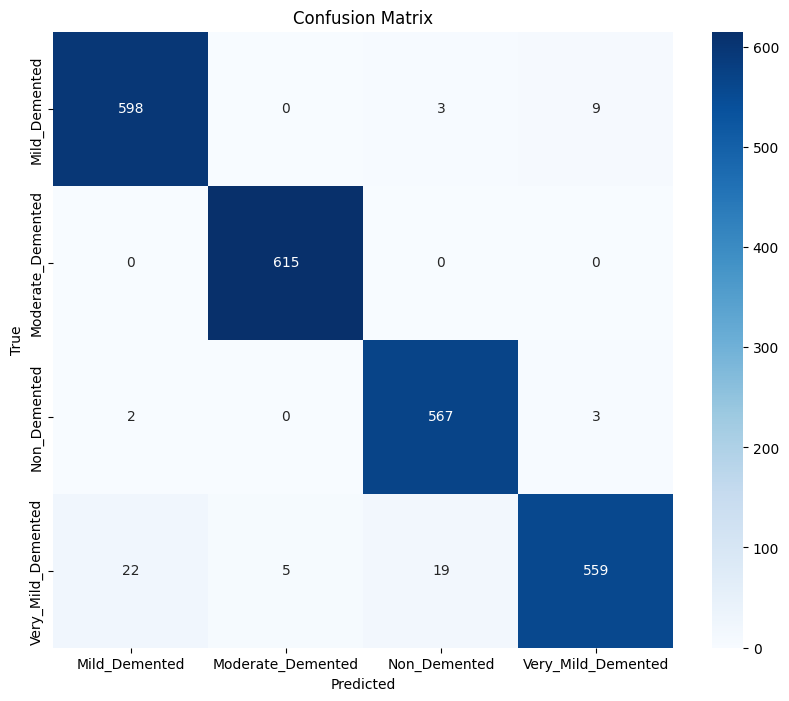

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# VGG16_DenseNet121

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19,DenseNet121
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



#VGG16
vgg = VGG16(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
vgg.trainable = False


#DenseNet121
densenet = DenseNet121(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
densenet.trainable = False

input_layer = Input(shape=(128, 128, 3))

vgg_features = vgg(input_layer)
densenet_features = densenet(input_layer)


# Concatenate features
merged_features = Concatenate()([vgg_features,densenet_features])


x = Dense(512, activation='relu')(merged_features)
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=x)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25)

Epoch 1/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 67s 80ms/step - accuracy: 0.4854 - loss: 1.5849 - val_accuracy: 0.7993 - val_loss: 0.5295
Epoch 2/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - accuracy: 0.8392 - loss: 0.4445 - val_accuracy: 0.8701 - val_loss: 0.3670
Epoch 3/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.8948 - loss: 0.3100 - val_accuracy: 0.8955 - val_loss: 0.2937
Epoch 4/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.9195 - loss: 0.2401 - val_accuracy: 0.9109 - val_loss: 0.2529
Epoch 5/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.9396 - loss: 0.1936 - val_accuracy: 0.9242 - val_loss: 0.2078
Epoch 6/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.9522 - loss: 0.1608 - val_accuracy: 0.9276 - val_loss: 0.1974
Epoch 7/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.9601 - loss: 0.1334 - val_accuracy: 0.9317 - val_loss: 0.1726
Epoch 8/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 31s 51ms/step - accuracy: 0.9634 - loss: 0.1231 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.9761 - loss: 0.0651
Test Loss: 0.07074443250894547
Test Accuracy: 0.9725229144096375


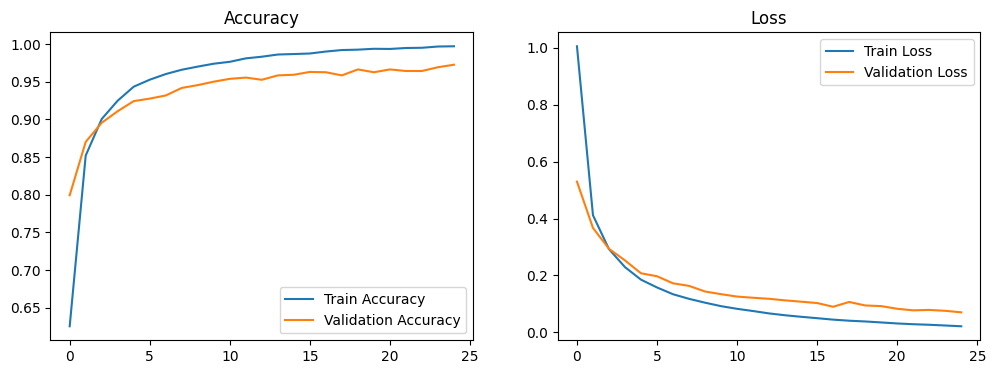

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


151/151 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.94      0.98      0.96       610
 Moderate_Demented       0.99      1.00      1.00       615
      Non_Demented       0.99      0.99      0.99       572
Very_Mild_Demented       0.97      0.92      0.95       605

          accuracy                           0.97      2402
         macro avg       0.97      0.97      0.97      2402
      weighted avg       0.97      0.97      0.97      2402



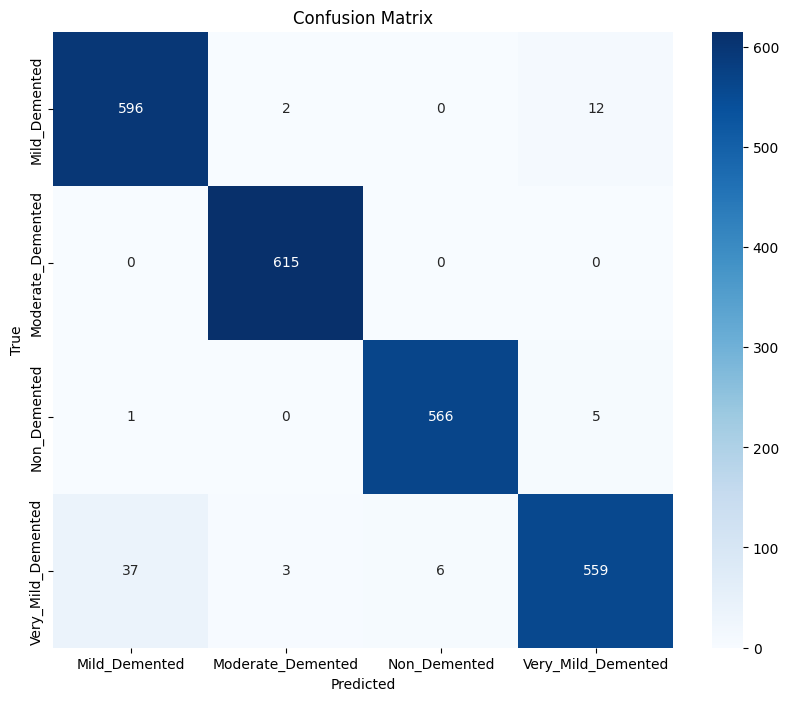

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)

# VGG16_DenseNet169

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet169, VGG16
from tensorflow.keras.layers import Dense, Dropout, Flatten, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam



#VGG16
vgg = VGG16(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
vgg.trainable = False


#DenseNet169
densenet = DenseNet169(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
densenet.trainable = False


input_layer = Input(shape=(128, 128, 3))

vgg_features = vgg(input_layer)
densenet_features = densenet(input_layer)


# Concatenate features
merged_features = Concatenate()([vgg_features,densenet_features])
x = Dense(256, activation='relu')(merged_features)
x = Dense(256, activation='relu')(x)
x = Dense(4, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=x)


model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=25
)

Epoch 1/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 81s 95ms/step - accuracy: 0.4363 - loss: 2.0664 - val_accuracy: 0.7731 - val_loss: 0.5879
Epoch 2/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 36s 60ms/step - accuracy: 0.7985 - loss: 0.5324 - val_accuracy: 0.8576 - val_loss: 0.3899
Epoch 3/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.8745 - loss: 0.3598 - val_accuracy: 0.8943 - val_loss: 0.3013
Epoch 4/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9110 - loss: 0.2827 - val_accuracy: 0.9113 - val_loss: 0.2456
Epoch 5/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9268 - loss: 0.2264 - val_accuracy: 0.9276 - val_loss: 0.2213
Epoch 6/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9414 - loss: 0.1958 - val_accuracy: 0.9409 - val_loss: 0.1897
Epoch 7/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9474 - loss: 0.1796 - val_accuracy: 0.9438 - val_loss: 0.1679
Epoch 8/25
601/601 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9540 - loss: 0.1522 - 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


151/151 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9765 - loss: 0.0707
Test Loss: 0.06826826184988022
Test Accuracy: 0.9754371643066406


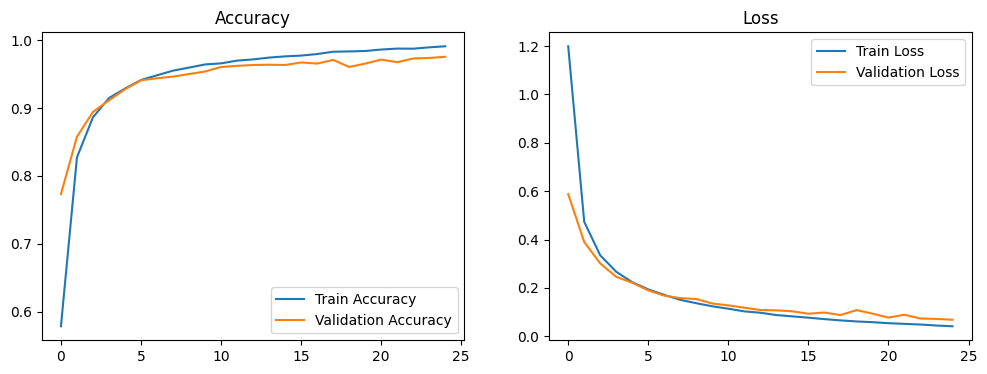

In [ ]:
def plot_training_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(history.history['accuracy'], label='Train Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_title('Accuracy')
    ax[0].legend()

    ax[1].plot(history.history['loss'], label='Train Loss')
    ax[1].plot(history.history['val_loss'], label='Validation Loss')
    ax[1].set_title('Loss')
    ax[1].legend()
    plt.show()

plot_training_history(history)


151/151 ━━━━━━━━━━━━━━━━━━━━ 27s 114ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.96      0.96       571
 Moderate_Demented       0.98      1.00      0.99       587
      Non_Demented       1.00      0.99      0.99       656
Very_Mild_Demented       0.96      0.95      0.96       588

          accuracy                           0.98      2402
         macro avg       0.97      0.97      0.97      2402
      weighted avg       0.98      0.98      0.98      2402



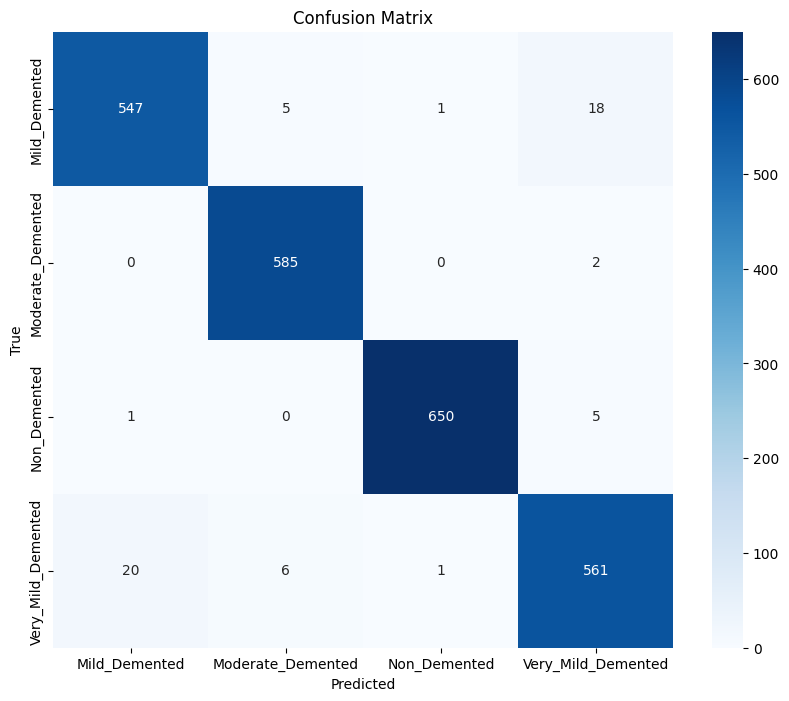

In [ ]:
def evaluate_model(model, val_data):
    val_data.reset()
    predictions = model.predict(val_data)
    y_pred = np.argmax(predictions, axis=1)
    y_true = val_data.classes
    class_labels = list(val_data.class_indices.keys())
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_labels))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

evaluate_model(model, test_data)